# Gradient descent on bandwidth parameter (1-dim)

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import time

In [ ]:
n=100
d=1
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
bandwidth = 1

from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))

# Define optimizer

In [4]:
svgd_stepsize = stepsize

def loss(rkey, bandwidth, ksd_bandwidth=1):
    """Sample particles, perform SVGD, and output estimated KSD between target p and particles xout."""
    xout, _ = svgd_fix.svgd(rkey, svgd_stepsize, bandwidth, n_iter_max)
    return ksd(xout, logp, ksd_bandwidth)

@jit
def update_bandwidth(rkey, bandwidth, stepsize):
    bandwidth = np.array(bandwidth, dtype=np.float32)
    return bandwidth - stepsize * jacfwd(loss, argnums=1)(rkey, bandwidth)

def optimize_bandwidth(bandwidth, stepsize, n_steps):
    log = [bandwidth]
    for step in tqdm(range(n_steps)):
        svgd_fix.newkey()
        bandwidth = update_bandwidth(svgd_fix.rkey, bandwidth, stepsize)
        log.append(bandwidth)
    return bandwidth, log

# Experiments
## 1
* Plot KSD and grad(KSD) for bandwidths 0, ..., 10.000.
* Optimize bandwidth, initializing at various points along the bandwidth grid.

#### Note
You're gonna get `NaN`s for your gradients as soon as the bandwidth is smaller than 0.25 (the gradient becomes very large). If you really want to, you can set JAX to use float64s,
```
from jax.config import config
config.update("jax_enable_x64", True)
```
in which case NaNs will start appearing once bandwidth is somewhere below 0.1, the gradient growing to something like $10^{259}$ shortly before that.

In [5]:
svgd_fix.newkey()
xout, _ = svgd_fix.svgd(svgd_fix.rkey, stepsize, bandwidth=1, n_iter=200)
np.mean(xout)

JIT COMPILING...
Done compiling in 0.40851879119873047 seconds.


DeviceArray(-0.00040539, dtype=float32)

In [ ]:
bandwidth_grid = np.logspace(-0.5, 3, num=20)
losses = np.array([loss(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])

st = time.time()
grad_losses = np.array([jacfwd(loss, argnums=1)(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])
end = time.time()
print(end - st)

JIT COMPILING...
Done compiling in 2.3838586807250977 seconds.


In [ ]:
st = time.time()
grad_losses2 = np.array([jacfwd(loss, argnums=1)(rkey, h) for rkey, h in zip(random.split(svgd_fix.rkey, len(bandwidth_grid)), bandwidth_grid)])
end = time.time()
print(end - st)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/matplotlib/ticker.py:2502: RuntimeWarning: overflow encountered in power
  ticklocs = b ** decades
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/matplotlib/ticker.py:2345: RuntimeWarning: invalid value encountered in double_scalars
  return abs(x - np.round(x)) < atol
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/matplotlib/ticker.py:1123: RuntimeWarning: invalid value encountered in double_scalars
  coeff = round(x / b ** exponent)


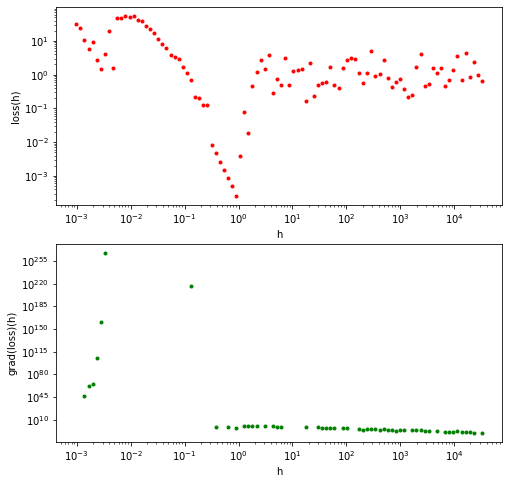

In [9]:
plt.figure(1, figsize=[8, 8])

plt.subplot(211)
plt.plot(bandwidth_grid, losses, "r.")
plt.xlabel("h")
plt.ylabel("loss(h)")
plt.yscale("log")
plt.xscale("log")

plt.subplot(212)
plt.plot(bandwidth_grid, grad_losses, "g.")
plt.xlabel("h")
plt.ylabel("grad(loss)(h)")
plt.yscale("log")
plt.xscale("log")

In [29]:
plt.figure(1, figsize=[8, 4])
plt.plot(bandwidth_grid, grad_losses2, "b.")
plt.xlabel("h")
plt.ylabel("grad(loss)(h)")
plt.yscale("log")
plt.xscale("log")

NameError: name 'grad_losses2' is not defined

<Figure size 576x288 with 0 Axes>

In [14]:
bandwidth_grid[np.isnan(grad_losses)]

DeviceArray([0.00396133, 0.0047191 , 0.00562182, 0.00669722, 0.00797833,
             0.00950451, 0.01132263, 0.01348855, 0.01606878, 0.01914258,
             0.02280438, 0.02716664, 0.03236336, 0.03855416, 0.0459292 ,
             0.05471502, 0.06518149, 0.07765008], dtype=float64)

## Linear plots

In [16]:
rkey = random.PRNGKey(0)

bandwidth_grid = np.linspace(1, 7, num=100) # NaNs when h < 0.01
sample_each_time = False

In [17]:
if sample_each_time:
    rkeys = random.split(svgd_fix.rkey, len(bandwidth_grid))
else:
    rkeys = [rkey] * len(bandwidth_grid)

st = time.time()
losses = np.array([loss(rkey, h) for rkey, h in zip(rkeys, bandwidth_grid)])
end = time.time()
print(end - st, "seconds elapsed.")


st = time.time()
grad_losses = np.array([jacfwd(loss, argnums=1)(rkey, h) for rkey, h in zip(rkeys, bandwidth_grid)])
end = time.time()
print(end - st, "seconds elapsed.")

JIT COMPILING...
Done compiling in 1.1541845798492432 seconds.
33.416606187820435 seconds elapsed.
JIT COMPILING...
Done compiling in 4.511339426040649 seconds.
72.17807793617249 seconds elapsed.


Text(0, 0.5, 'grad(loss)(h)')

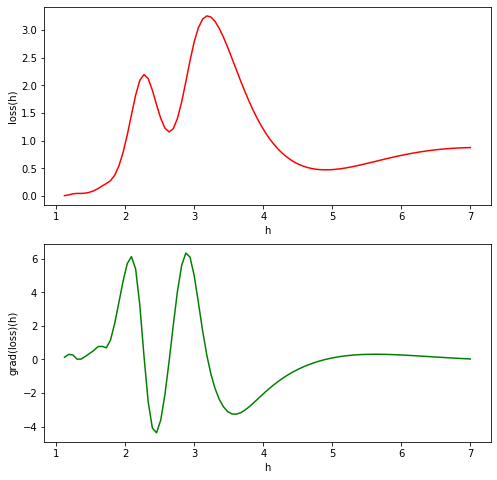

In [28]:
plt.figure(1, figsize=[8, 8])

l = 2
u = 100

plt.subplot(211)
plt.plot(bandwidth_grid[l:u], losses[l:u], "r")
plt.xlabel("h")
plt.ylabel("loss(h)")
xlim = plt.axis()[:2]
ylim = plt.axis()[2:]
# plt.yscale("log")

plt.subplot(212)
plt.plot(bandwidth_grid[l:u], grad_losses[l:u], "g")
plt.xlabel("h")
plt.ylabel("grad(loss)(h)")
# plt.yscale("log")

# plt.xlim(xlim)
# plt.ylim(ylim)

In [20]:
np.any(np.isnan(grad_losses))

DeviceArray(False, dtype=bool)

## Do some gradient descent

In [13]:
opt_h[0]

DeviceArray(5.054671, dtype=float32)

In [26]:
h = 2.5
opt_h, log1 = optimize_bandwidth(h, 0.1, n_steps=100)
print(opt_h)

100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


0.9005224


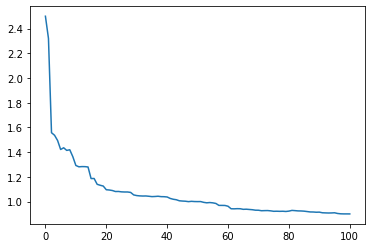

In [27]:
plt.plot(log1)

In [24]:
h = 3
opt_h, log = optimize_bandwidth(h, 0.1, n_steps=100)
print(opt_h)

100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


0.92745847


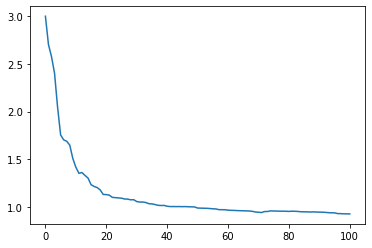

In [25]:
plt.plot(log)